In [74]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
dataset = pd.read_excel("tüketim.xlsx",index_col=0)

In [86]:
dataset.head()

,Net consumption(GWh)
Year,
1975,13491.7
1976,16078.9
1977,17968.8
1978,18933.8
1979,19633.1


In [87]:
dataset.dtypes

Net consumption(GWh)    float64
dtype: object

In [88]:
#dataset["Year"] = pd.to_datetime(dataset["Year"], format='%Y')

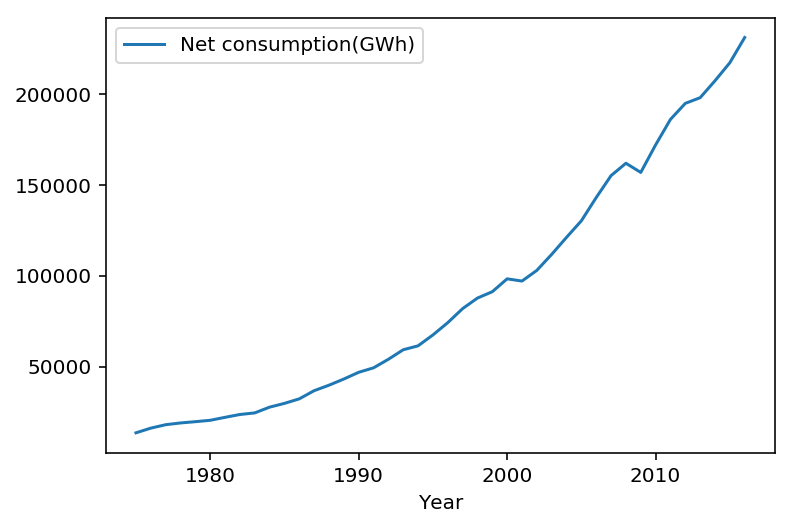

In [89]:
dataset.plot()
plt.show()

In [90]:
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import math
import os

Using TensorFlow backend.


In [91]:
data = dataset.iloc[:,0].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
data = scaler.fit_transform(data)

In [93]:
NUM_TIMESTEPS = 5
max_elements = len(data) - NUM_TIMESTEPS - 1
X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]
    
    
# reshape X to three dimensions (samples, timesteps, features)
X = np.expand_dims(X, axis=2)
#X = X.reshape(X.shape[0], X.shape[1], 1)

X = X[:max_elements]
Y = Y[:max_elements]

In [95]:
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(29, 5, 1) (7, 5, 1) (29, 1) (7, 1)


In [148]:
NUM_EPOCHS = 250
BATCH_SIZE = 5 

np.random.seed(123456)

# stateless
def build_model_stateless():
    model = Sequential()
    model.add(LSTM(10, input_shape=(NUM_TIMESTEPS, 1), return_sequences=False))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
    return model
    

In [149]:
model_stateless = build_model_stateless()

early_stopping = EarlyStopping(patience=2)
history = model_stateless.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(Xtest, Ytest), shuffle=False, callbacks=[early_stopping], verbose=0)

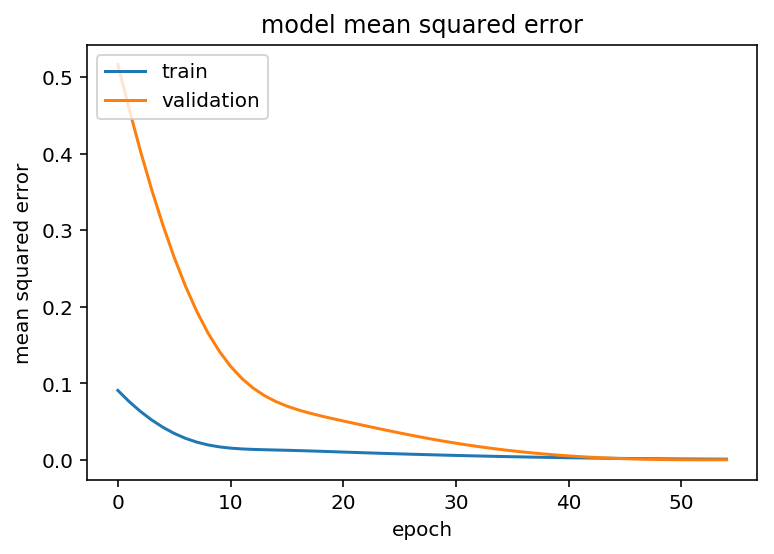

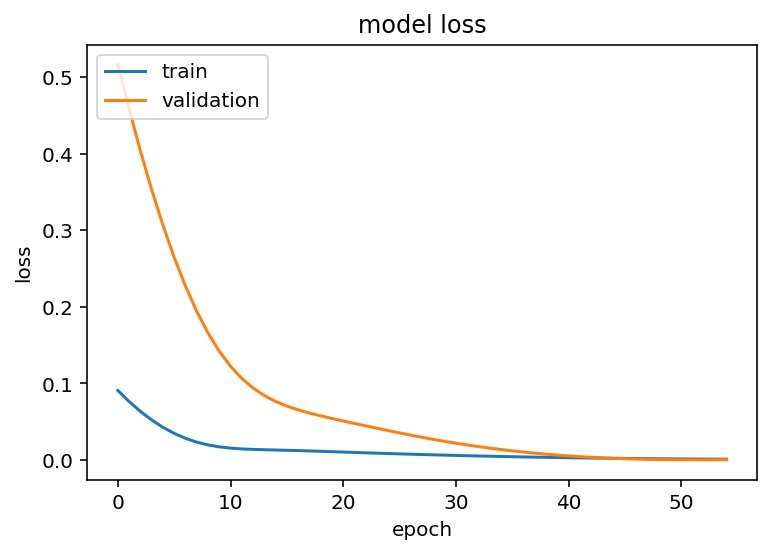

In [150]:
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
_=plt.show()

In [151]:
test_length = NUM_TIMESTEPS
dataset_train = dataset.iloc[0:-test_length,:]

In [152]:
last_point = dataset_train.iloc[-NUM_TIMESTEPS:, 0].values.reshape(1, NUM_TIMESTEPS)
last_point_scaled = scaler.transform(last_point)
last_point_scaled = last_point_scaled.reshape(1, NUM_TIMESTEPS, 1)

In [153]:
num_predictions = test_length + 10
year_ini = dataset_train.index[-1] + 1 

In [154]:
last_x = last_point_scaled
predictions = []
years = []
for i in range(num_predictions):
    pred_tmp = model_stateless.predict(last_x)
    pred = scaler.inverse_transform(pred_tmp)
    predictions.append(pred[0][0])
    years.append(year_ini+i)
    next_x = np.roll(last_x, 1)
    next_x[0,0] = pred_tmp
    last_x = next_x

predictions_df = pd.DataFrame({'Forecast':predictions}, index=years)

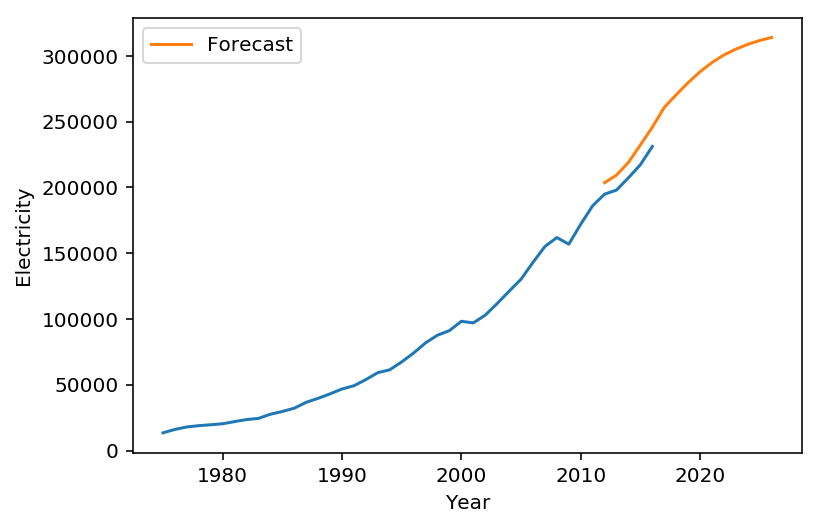

In [155]:
ax = dataset.iloc[:,0].plot()
predictions_df.plot(ax=ax)
plt.ylabel("Electricity")
plt.show()

In [156]:
predictions_df

,Forecast
2012,203659.109375
2013,209420.656250
2014,219074.703125
2015,232379.328125
2016,245853.859375
2017,260869.468750
2018,270481.625000
2019,279715.937500
2020,288013.593750
2021,294999.968750


In [157]:
pred_errors = dataset.iloc[-test_length:, 0].values - predictions_df.iloc[:test_length,0].values

In [158]:
np.sqrt(np.mean(pred_errors**2))

12523.871946766925

In [159]:
score, acc = model_stateless.evaluate(Xtest, Ytest)

7/7 [==============================] - 0s 711us/step


In [160]:
import numpy
cvscores = []
scores = model_stateless.evaluate(Xtest, Ytest, verbose=0)
print("%s: %.2f%%" % (model_stateless.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

mean_squared_error: 0.02%
0.02% (+/- 0.00%)
